In [1]:
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')
db = client.companies

In [5]:
df_schools=db.compSchools.find()

In [6]:
import pandas as pd
df_schools=pd.DataFrame(df_schools)

In [9]:
df_schools.shape

(27, 5)

In [16]:
def findInArea(geopoint,radio_max=2200000):
    return db.compSchools.find({
        "Offices":{
            "$near": {
                "$geometry": geopoint,
                "$maxDistance":radio_max,
            }
        }
    })
geopoint={
    "type":"Point",
    "coordinates": [-73.968285,40.785091]
}
df_schools=findInArea(geopoint)
df_schools=pd.DataFrame(df_schools)
df_schools.shape

(15, 5)

In [17]:
def findInArea1M(geopoint,radio_max=2200000):
    return db.comp1M.find({
        "Offices":{
            "$near": {
                "$geometry": geopoint,
                "$maxDistance":radio_max,
            }
        }
    })
df_1M=pd.DataFrame(findInArea1M(geopoint))
df_1M.shape


(1162, 5)

In [18]:
def findInArea10Y(geopoint,radio_max=2200000):
    return db.comp10Y.find({
        "Offices":{
            "$near": {
                "$geometry": geopoint,
                "$maxDistance":radio_max,
            }
        }
    })
df_10Y=pd.DataFrame(findInArea10Y(geopoint))
df_10Y.shape

(3125, 5)

In [19]:
def findInAreaDesign(geopoint,radio_max=2200000):
    return db.compDesign.find({
        "Offices":{
            "$near": {
                "$geometry": geopoint,
                "$maxDistance":radio_max,
            }
        }
    })
df_design=pd.DataFrame(findInAreaDesign(geopoint))
df_design.shape

(3, 5)

In [23]:
def findInAreaAerop(geopoint,radio_max=2200000):
    return db.aeropuertos.find({
        "Localizacion":{
            "$near": {
                "$geometry": geopoint,
                "$maxDistance":radio_max,
            }
        }
    })
df_aer=pd.DataFrame(findInAreaAerop(geopoint))
df_aer.shape

(1117, 6)

In [28]:
empresasMas10=list(df_10Y["Name"].values)
latMas10=list(df_10Y["Longitude"].values)
lonMas10=list(df_10Y["Latitude"].values)


In [35]:
import math

def haversine(lat1, lon1, lat2, lon2):
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia

def calcularDistancias(x): 
    empresa=[]
    for i in range(len(empresasMas10)):
        dist=haversine(x["Longitude"],x["Latitude"],latMas10[i],lonMas10[i])
        if dist<2: #No queremos la empresa
            empresa.append(empresasMas10[i])
            
    return {
        "Empresa": x["Name"],
        "EmpresasMenosDistancia": empresa,
        "Cantidad": len(empresa)
    }

df_desCerca = df_design.apply(calcularDistancias,result_type="expand",axis=1)
df_desCerca[df_desCerca["Cantidad"] == df_desCerca["Cantidad"].min()]  
    
    

,Cantidad,Empresa,EmpresasMenosDistancia
1,7,Refinery29,"[Dadaphile, Frogmetrics, Refinery29, GEN247, V..."


In [36]:
df_1MCerca=df_1M.apply(calcularDistancias,result_type="expand",axis=1)
print(df_1MCerca.shape)
df_1M.shape

(1162, 3)


(1162, 5)

In [38]:
df_1MCerca=df_1MCerca[df_1MCerca["Cantidad"] == df_1MCerca["Cantidad"].min()]
df_1MCerca.shape

(54, 3)

In [40]:
def calcularDistanciasAe(x): 
    empresa=[]
    for i in range(len(empresasMas10)):
        dist=haversine(x["Latitude"],x["Longitude"],latMas10[i],lonMas10[i])
        if dist<2: #No queremos la empresa
            empresa.append(empresasMas10[i])
            
    return {
        "Empresa": x["Name"],
        "EmpresasMenosDistancia": empresa,
        "Cantidad": len(empresa)
    }
df_aeCerca=df_aer.apply(calcularDistanciasAe,result_type="expand",axis=1)

In [41]:
print(df_aeCerca["Cantidad"].min())
df_aeCerca=df_aeCerca[df_aeCerca["Cantidad"] == df_aeCerca["Cantidad"].min()]
df_aeCerca.shape

0


(1087, 3)

In [42]:
df_sCerca=df_schools.apply(calcularDistancias,result_type="expand",axis=1)


In [44]:
print(df_sCerca["Cantidad"].min())
df_sCerca=df_sCerca[df_sCerca["Cantidad"] == df_sCerca["Cantidad"].min()]
df_sCerca.head()

1


,Cantidad,Empresa,EmpresasMenosDistancia
2,1,ePrep,[ePrep]
7,1,Tizmos,[Tizmos]
8,1,Skoodat,[Skoodat]
13,1,Edmodo,[Edmodo]


In [60]:
def empresasConMenosDist(x):
    name=None
    if x["Name"] in list(df_sCerca["Empresa"].values):
        name=x["Name"]
        off=x["Offices"]
        lat=x["Latitude"]
        lon=x["Longitude"]
    else:
        name=None
        off=None
        lat=None
        lon=None
    return {
        "Name": name,
        "Offices": off,
        "Latitude":lat,
        "Longitude":lon
    }
        
df_sImp = df_schools.apply(empresasConMenosDist,result_type="expand",axis=1)
df_sImp = df_sImp.dropna(axis=0)



,Latitude,Longitude,Name,Offices
2,-74.649912,40.396817,ePrep,"{'type': 'Point', 'coordinates': [-74.649912, ..."
7,-86.877244,40.440278,Tizmos,"{'type': 'Point', 'coordinates': [-86.877244, ..."
8,-85.350930,34.970710,Skoodat,"{'type': 'Point', 'coordinates': [-85.3509296,..."
13,-88.321171,41.857915,Edmodo,"{'type': 'Point', 'coordinates': [-88.321171, ..."


In [62]:
def empresasConMenosDistAe(x):
    name=None
    if x["Name"] in list(df_aeCerca["Empresa"].values):
        name=x["Name"]
        off=x["Localizacion"]
        lat=x["Latitude"]
        lon=x["Longitude"]
    else:
        name=None
        off=None
        lat=None
        lon=None
    return {
        "Name": name,
        "Offices": off,
        "Latitude":lat,
        "Longitude":lon
    }
        
df_aeImp = df_aer.apply(empresasConMenosDistAe,result_type="expand",axis=1)
df_aeImp = df_aeImp.dropna(axis=0)

In [63]:
df_aeImp.shape

(1087, 4)

In [64]:
def empresasConMenosDist1M(x):
    name=None
    if x["Name"] in list(df_1MCerca["Empresa"].values):
        name=x["Name"]
        off=x["Offices"]
        lat=x["Latitude"]
        lon=x["Longitude"]
    else:
        name=None
        off=None
        lat=None
        lon=None
    return {
        "Name": name,
        "Offices": off,
        "Latitude":lat,
        "Longitude":lon
    }
        
df_1MImp = df_des.apply(empresasConMenosDist1M,result_type="expand",axis=1)
df_1MImp = df_1MImp.dropna(axis=0)

df_1MImp.shape

(54, 4)

In [68]:
def empresasConMenosDistDes(x):
    name=None
    if x["Name"] in list(df_desCerca["Empresa"].values):
        name=x["Name"]
        off=x["Offices"]
        lat=x["Latitude"]
        lon=x["Longitude"]
    else:
        name=None
        off=None
        lat=None
        lon=None
    return {
        "Name": name,
        "Offices": off,
        "Latitude":lat,
        "Longitude":lon
    }
df_desCerca=df_desCerca[df_desCerca["Cantidad"] == df_desCerca["Cantidad"].min()]
df_desImp=df_design.apply(empresasConMenosDistDes,result_type="expand",axis=1)
df_desImp=df_desImp.dropna(axis=0)
df_desImp

,Latitude,Longitude,Name,Offices
1,-73.950821,40.727719,Refinery29,"{'type': 'Point', 'coordinates': [-73.9508211,..."


In [69]:
def concatenar(x):
    categoria=None
    if x["Name"] in list(df_desCerca["Empresa"].values):
        categoria="Empresa diseño"
        lat=x["Longitude"]
        lon=x["Latitude"]
        loc=x["Offices"]
    elif x["Name"] in list(df_1MCerca["Empresa"].values):
        categoria="1M"
        lat=x["Longitude"]
        lon=x["Latitude"]
        loc=x["Offices"]
    elif x["Name"] in list(df_sCerca["Empresa"].values):
        categoria="Colegio"
        lat=x["Longitude"]
        lon=x["Latitude"]
        loc=x["Offices"]
    elif x["Name"] in list(df_aeCerca["Empresa"].values):
        categoria="Aeropuerto"
        lat=x["Latitude"]
        lon=x["Longitude"]
        loc=x["Offices"]
    
    return {
        "Name": x["Name"],
        "Categoria": categoria,
        "Latitude": lat,
        "Longitude":lon,
        "Localizacion":loc
        
    }
df_aeImp=df_aeImp.rename({"Localizacion":"Offices"})


In [72]:
df_Imp=pd.concat([df_aeImp,df_desImp,df_1MImp,df_sImp],axis=0)
df_Imp.shape

(1146, 4)

In [73]:
df_final=df_Imp.apply(concatenar,result_type="expand",axis=1)
df_final.shape

(1146, 5)

In [74]:
df_final.head()

,Categoria,Latitude,Localizacion,Longitude,Name
4,Aeropuerto,40.850101,"{'type': 'Point', 'coordinates': [-74.06079864...",-74.060799,Teterboro Airport
5,Aeropuerto,40.692501,"{'type': 'Point', 'coordinates': [-74.16870117...",-74.168701,Newark Liberty International Airport
6,Aeropuerto,40.639801,"{'type': 'Point', 'coordinates': [-73.77890015...",-73.778900,John F Kennedy International Airport
7,Aeropuerto,40.875198,"{'type': 'Point', 'coordinates': [-74.28140258...",-74.281403,Essex County Airport
8,Aeropuerto,40.617401,"{'type': 'Point', 'coordinates': [-74.24459838...",-74.244598,Linden Airport


In [75]:
df_final.to_json("Mezcla.json",default_handler=str,orient="records")

In [77]:
import geocoder
loc=geocoder.google("Starbucks, New Jersey")
loc

<[REQUEST_DENIED] Google - Geocode [empty]>

In [81]:
import os
from dotenv import load_dotenv
import requests
load_dotenv()
BASE_URL="https://maps.googleapis.com/maps/api/place/textsearch/json?"
parameters="input=starbucks+new+jersey"
parameters2="&inputtype=textquery"
key="&key="+ os.environ["KEY"]

res=requests.get(BASE_URL+parameters+parameters2+key)
res=res.json()
#res

{'html_attributions': [],
 'next_page_token': 'CpQCAwEAAEg0HBzc2wczGSYkjtqYc4d6-Slleytg3m3BQhsASlYuwDeHSFep7LAkbDcxuh4O3Psp5jwMTIa0xl-ZpOmLp1_QZc-G3paXotcRxkJsTIOWGiew2caKJXEttC0GjCHsFliJQKRtFeU9ONFw1stXvICi3s5h-g7aqpv_jvaI3aZnS8P-oDteRDTnQAtCpAupii1tKHGU7FZjwoaMmDSSisXDHQZcTbbKP-JBonpuvdifsXutG-Dag5fLI5Ag1t4ZYMoUrdDH6UlmQ-ZE610mfEkWJDnC_vyKOnQm7sHqEepjNvERqsA5_TRDkyGkq7mVsfUcI0XDTJlVTSMIMsGPOWTbG4e9Dc83ZMeu8GT_F7vgEhBhdUo8Xj6aSISLB0jhu8wuGhSAsp0FcMGl8gq6yBc2PNsGIoMG_Q',
 'results': [{'formatted_address': '1865 NJ-70, Lakewood, NJ 08701, USA',
   'geometry': {'location': {'lat': 40.055727, 'lng': -74.16485},
    'viewport': {'northeast': {'lat': 40.05706572989272,
      'lng': -74.16357772010727},
     'southwest': {'lat': 40.05436607010728, 'lng': -74.16627737989272}}},
   'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/cafe-71.png',
   'id': '981fd65bcdc7fabd3aaef1f560e2ff0b63a27089',
   'name': 'Starbucks',
   'opening_hours': {'open_now': True},
   'photos': [{'height': 

In [85]:
resultados = list(res["results"])

In [86]:
lat=[]
lon=[]
for e in resultados:
    lat.append(e.get("geometry").get("location").get("lat"))
    lon.append(e.get("geometry").get("location").get("lng"))
d={
    "Latitude": lat,
    "Longitude": lon
}
df_st=pd.DataFrame(d)
df_st.head()

,Latitude,Longitude
0,40.055727,-74.164850
1,39.936742,-75.045005
2,40.264683,-74.042442
3,40.219624,-74.632385
4,40.456454,-74.400224


In [87]:
df_st.to_json("Starbucks.json",default_handler=str,orient="records")

In [88]:
BASE_URL="https://maps.googleapis.com/maps/api/place/textsearch/json?"
parameters="input=school+new+jersey"
parameters2="&inputtype=textquery"
key="&key="+ os.environ["KEY"]

res2=requests.get(BASE_URL+parameters+parameters2+key)
res2=res2.json()

In [90]:
name_sc=[]
lat2=[]
lon2=[]
for e in res2["results"]:
    name_sc.append(e.get("name"))
    lat2.append(e.get("geometry").get("location").get("lat"))
    lon2.append(e.get("geometry").get("location").get("lng"))

d2={
    "Name": name_sc,
    "Latitude": lat2,
    "Longitude":lon2
}
df_schoolsImport=pd.DataFrame(d2)
df_schoolsImport.head()

,Name,Latitude,Longitude
0,New Jersey School Boards Association,40.225425,-74.778654
1,Winston Preparatory School,40.824704,-74.429523
2,Collegiate School,40.853135,-74.133088
3,New Jersey Association of Independent Schools ...,40.798687,-74.485854
4,The Deron School of New Jersey,40.703665,-74.278263


In [91]:
df_schoolsImport.shape

(20, 3)

In [92]:
df_schoolsImport.to_json("SchoolsNJ.json",default_handler=str,orient="records")

In [93]:
BASE_URL="https://maps.googleapis.com/maps/api/place/textsearch/json?"
parameters="input=vegan+restaurant+new+jersey"
parameters2="&inputtype=textquery"
key="&key="+ os.environ["KEY"]

res3=requests.get(BASE_URL+parameters+parameters2+key)
res3=res3.json()

In [95]:
name_veg=[]
lat3=[]
lon3=[]
for e in res3["results"]:
    name_veg.append(e.get("name"))
    lat3.append(e.get("geometry").get("location").get("lat"))
    lon3.append(e.get("geometry").get("location").get("lng"))

d3={
    "Name": name_veg,
    "Latitude": lat3,
    "Longitude":lon3
}
df_VeganRestImport=pd.DataFrame(d3)
df_VeganRestImport.head()

,Name,Latitude,Longitude
0,Killer Vegan,40.696338,-74.270283
1,Veganized,40.495519,-74.445155
2,Mundo Vegan,40.813753,-74.218367
3,Blueberry Cafe Juice Bar And Vegan Grille,40.749374,-74.196672
4,Wildflower Vegan Cafe,39.401026,-75.038465


In [96]:
df_VeganRestImport.to_json("VeganRestaurants.json",default_handler=str,orient="records")

In [97]:
df_final.head()

,Categoria,Latitude,Localizacion,Longitude,Name
4,Aeropuerto,40.850101,"{'type': 'Point', 'coordinates': [-74.06079864...",-74.060799,Teterboro Airport
5,Aeropuerto,40.692501,"{'type': 'Point', 'coordinates': [-74.16870117...",-74.168701,Newark Liberty International Airport
6,Aeropuerto,40.639801,"{'type': 'Point', 'coordinates': [-73.77890015...",-73.778900,John F Kennedy International Airport
7,Aeropuerto,40.875198,"{'type': 'Point', 'coordinates': [-74.28140258...",-74.281403,Essex County Airport
8,Aeropuerto,40.617401,"{'type': 'Point', 'coordinates': [-74.24459838...",-74.244598,Linden Airport


In [118]:
df_1M1=df_final[df_final["Categoria"]=="1M"][["Latitude","Longitude","Name"]]

In [122]:
emp1M= df_1M1[df_1M1["Latitude"]==40.829813]
emp1M

,Latitude,Longitude,Name
274,40.829813,-74.320006,Expand Networks


In [135]:
df_aerop1=df_final[df_final["Categoria"]=="Aeropuerto"][["Latitude","Longitude","Name"]]

In [248]:
empaer=df_aerop1[(df_aerop1["Name"]=="Teterboro Airport")]

In [249]:
empaer

,Latitude,Longitude,Name
4,40.850101,-74.060799,Teterboro Airport


In [250]:
df_design1=df_final[df_final["Categoria"]=="Empresa diseño"][["Latitude","Longitude","Name"]]

In [251]:
empdes=df_design1[(df_design1["Latitude"]>=40.7) & (df_design1["Latitude"]<40.8)]

In [252]:
empdes

,Latitude,Longitude,Name
1,40.727719,-73.950821,Refinery29


In [253]:
df_st["Name"]="Starbucks"

In [254]:
df_st.head()

,Latitude,Longitude,Name
0,40.055727,-74.164850,Starbucks
1,39.936742,-75.045005,Starbucks
2,40.264683,-74.042442,Starbucks
3,40.219624,-74.632385,Starbucks
4,40.456454,-74.400224,Starbucks


In [255]:
empSt= df_st[(df_st["Latitude"]>=40.856712) & (df_st["Latitude"]<40.88)]

In [256]:
empSt

,Latitude,Longitude,Name
7,40.856712,-74.07034,Starbucks


In [257]:
escuela=df_schoolsImport[(df_schoolsImport["Latitude"]>=40.85313)&(df_schoolsImport["Latitude"]<40.86)]

In [258]:
escuela

,Name,Latitude,Longitude
2,Collegiate School,40.853135,-74.133088


In [259]:
restVeg=df_VeganRestImport[(df_VeganRestImport["Latitude"]>=40.878)&(df_VeganRestImport["Latitude"]<40.88)]

In [260]:
restVeg

,Name,Latitude,Longitude
14,Nefista Vegan Kofteh / Çiğ Köfte,40.878809,-74.143419


In [261]:
df_FINAL=pd.concat([empSt,restVeg,escuela,empdes,empaer,emp1M])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [262]:
df_FINAL

,Latitude,Longitude,Name
7,40.856712,-74.070340,Starbucks
14,40.878809,-74.143419,Nefista Vegan Kofteh / Çiğ Köfte
2,40.853135,-74.133088,Collegiate School
1,40.727719,-73.950821,Refinery29
4,40.850101,-74.060799,Teterboro Airport
274,40.829813,-74.320006,Expand Networks


In [263]:
lstlat=list(df_FINAL["Latitude"].values)

        
latMi=df_FINAL["Latitude"].mean()
lonMi=df_FINAL["Longitude"].mean()
nombre="MI EMPRESA"
print(latMi,lonMi)
d_miE={
    "Latitude": [latMi],
    "Longitude":[lonMi],
    "Name": [nombre]
    
}
df_miEmp=pd.DataFrame(d_miE)
df_Fin=pd.concat([df_FINAL,df_miEmp],axis=0)
df_Fin

40.83271497848333 -74.11307877416668


,Latitude,Longitude,Name
7,40.856712,-74.070340,Starbucks
14,40.878809,-74.143419,Nefista Vegan Kofteh / Çiğ Köfte
2,40.853135,-74.133088,Collegiate School
1,40.727719,-73.950821,Refinery29
4,40.850101,-74.060799,Teterboro Airport
274,40.829813,-74.320006,Expand Networks
0,40.832715,-74.113079,MI EMPRESA


In [264]:
df_Fin.to_json("MiEmpresa.json", default_handler=str,orient="records")

In [265]:
lstlat=list(df_FINAL["Latitude"].values)
lstlon=list(df_FINAL["Longitude"].values)
lstname=list(df_FINAL["Name"].values)
latsum=0.0
lonsum=0.0
for i in range(len(lstname)):
    if "Starbucks" in lstname[i]:
        latsum+=(lstlat[i]*0.7)
        lonsum+=(lstlon[i]*0.7)
        
    if "Vegan" in lstname[i]:
        latsum+=lstlat[i]*0.2
        lonsum+=lstlon[i]*0.2
        
    if "School" in lstname[i]:
        latsum+=lstlat[i]*0.1
        lonsum+=lstlon[i]*0.1

        
print(latsum,lonsum)

40.860773869999996 -74.09123044999998


In [266]:

nombre="MI EMPRESA"

d_miE2={
    "Latitude": [latsum],
    "Longitude":[lonsum],
    "Name": [nombre]
    
}
df_miEmp2=pd.DataFrame(d_miE2)
df_Fin2=pd.concat([df_FINAL,df_miEmp2],axis=0)
df_Fin2

,Latitude,Longitude,Name
7,40.856712,-74.070340,Starbucks
14,40.878809,-74.143419,Nefista Vegan Kofteh / Çiğ Köfte
2,40.853135,-74.133088,Collegiate School
1,40.727719,-73.950821,Refinery29
4,40.850101,-74.060799,Teterboro Airport
274,40.829813,-74.320006,Expand Networks
0,40.860774,-74.091230,MI EMPRESA


In [267]:
df_Fin2.to_json("MiEmpresa2.json", default_handler=str,orient="records")

In [268]:

#def haversine(lat1, lon1, lat2, lon2):
miE_lon=df_Fin2[df_Fin2["Name"]=="MI EMPRESA"]["Longitude"]
miE_lon=list(miE_lon.values)[0]
print(miE_lon)

miE_lat=df_Fin2[df_Fin2["Name"]=="MI EMPRESA"]["Latitude"]
miE_lat=list(miE_lat.values)[0]
miE_lat

-74.09123044999998


40.860773869999996

In [269]:
def dist(x):
    dist=haversine(x["Latitude"],x["Longitude"],miE_lat,miE_lon)
    return{
        "Name": x["Name"],
        "Latitude": x["Latitude"],
        "Longitude":x["Longitude"],
        "Distancia en KM": dist
    }
df_Fin2.apply(dist,result_type="expand",axis=1)

,Distancia en KM,Latitude,Longitude,Name
7,1.814534,40.856712,-74.070340,Starbucks
14,4.826206,40.878809,-74.143419,Nefista Vegan Kofteh / Çiğ Köfte
2,3.622315,40.853135,-74.133088,Collegiate School
1,18.942115,40.727719,-73.950821,Refinery29
4,2.821958,40.850101,-74.060799,Teterboro Airport
274,19.554834,40.829813,-74.320006,Expand Networks
0,0.000000,40.860774,-74.091230,MI EMPRESA


In [270]:
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import numpy as np
import seaborn

from matplotlib.colors import Normalize
import matplotlib.colors as colors
from numpy import array
from numpy import max

import mpl_toolkits
mpl_toolkits.__path__.append('/usr/lib/python2.7/dist-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

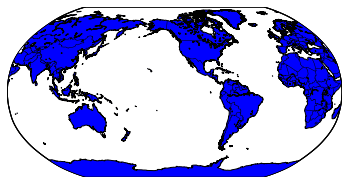

AttributeError: 'AxesSubplot' object has no attribute 'get_axis_bgcolor'

In [271]:
%matplotlib inline
e_map=Basemap(projection='robin',resolution='l',area_thresh=1000.0,lat_0=0,lon_0=-130)
e_map.drawcoastlines()
eq_map.drawcountries()
eq_map.fillcontinents(color = 'blue')
eq_map.drawmapboundary()
plt.show()

fill_color = ax.get_axis_bgcolor()
axisbgc = ax.get_axis_bgcolor()

In [ ]:
figu, ax = plt.subplots(figsize=(20,10))
eq_map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
eq_map.drawcoastlines()
eq_map.drawcountries()
eq_map.fillcontinents(color = 'gray')
eq_map.drawmapboundary()
eq_map.drawmeridians(np.arange(0, 360, 30))
eq_map.drawparallels(np.arange(-90, 90, 30))

lons=list(df_Fin2["Longitude"].values)
lats=list(df_Fin2["Latitude"].values)
x,y = eq_map(lons, lats)
eq_map.plot(x, y, '^', markersize=6)


plt.show()
fill_color = ax.get_axis_bgcolor()
axisbgc = ax.get_axis_bgcolor()
b = ax.ishold()
ax.hold(b)


In [ ]:
BASE_URL="https://maps.googleapis.com/v1/snapToRoads?"
parameters="path=40.856712,-74.070340|40.860774,-74.091230"
parameters2="&interpolate=true"
key="&key="+ os.environ["KEY"]

res=requests.get(BASE_URL+parameters+parameters2+key)
res=res.json()

In [ ]:
res

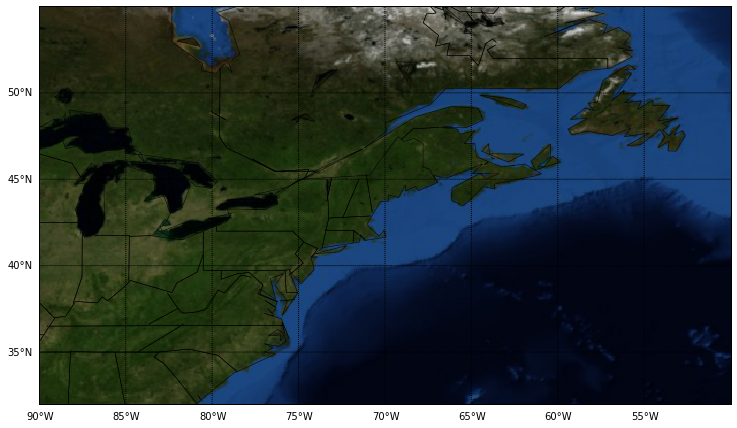

In [272]:
import matplotlib.pyplot as plt
from PIL import *
fig = plt.figure(figsize=(12,12))

ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(projection='cyl', llcrnrlat=32, urcrnrlat=55,llcrnrlon=-90, urcrnrlon=-50, resolution='c', area_thresh=1000.)

m.bluemarble()
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)


# --- Dibujamos paralelos y meridianos ---

m.drawparallels(np.arange(30.,55.,5.),labels=[1,0,0,1])
m.drawmeridians(np.arange(-90.,-50.,5.),labels=[1,0,0,1])
m.drawmapboundary(fill_color='aqua')

